# MVA - Homework 1 - Reinforcement Learning (2021/2022)

**Name:** VIOLANTE Nicolás


## Instructions

* The deadline is **November 12 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/ktmvsc4knke4ia?cid=6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [ ]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [ ]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [ ]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [ ]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


In [ ]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

a) If we apply an affine transformation $f(x) = \alpha x + \beta$ ,with $\alpha, \beta \in \mathbb{R} $, to the original reward $r_1(s_t, a_t)$, the new value function $v_2^\pi (s)$ is written as

$v_2^\pi (s) = \mathbb{E}_\pi[\sum_{t=0}^\infty \gamma^t(\alpha r_1(s_t, a_t) + \beta) | S_0 = s]$.

$v_2^\pi (s) =  \alpha\mathbb{E}_\pi[\sum_{t=0}^\infty \gamma^tr_1(s_t, a_t) | S_0 = s] + \beta \sum_{t=0}^\infty \gamma^t$ 

$v_2^\pi (s) = \alpha v_1^\pi (s) + \frac{\beta}{1-\gamma}$

b) The optimal value for a given state is

$v_2^*(s) = \max_\pi v_2^\pi(s)$

$v_2^*(s) = \max_\pi \{\alpha v_1^\pi(s) + \frac{\beta}{1-\gamma} \}$

$v_2^*(s) = \max_\pi \{\alpha v_1^\pi(s)\} + \frac{\beta}{1-\gamma}$

Rember that $v_1^*(s) = \max_\pi \{v_1^\pi(s)\}$. Therefore, if $\alpha > 0$ the optimal policy is preserved for all $\beta$. Note that in this case we have $v_2^*(s) = \alpha \max_\pi \{v_1^\pi(s)\} + \frac{\beta}{1-\gamma}$, thus the optimal policy is the same as before.

Conversely, if $\alpha < 0$ the optimal policy is not preserved since in this case we have $v_2^*(s) = |\alpha| \min_\pi \{v_1^\pi(s)\} + \frac{\beta}{1-\gamma}$

 The case $\alpha = 0$ is a special one where $v_2^*(s) = \frac{\beta}{1-\gamma}$ for all policies.



## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**
a)


$V^*(s) - V^{\pi_Q}(s) = (V^*(s) - Q(s, \pi_Q(s))) + (Q(s, \pi_Q(s)) - \mathcal{T}^{\pi_Q}V^*(s)) + (\mathcal{T}^{\pi_Q}V^*(s) - \mathcal{T}^{\pi_Q}V^{\pi_Q}(s))$

Where we used $\mathcal{T}^{\pi_Q}V^{\pi_Q}(s) = V^{\pi_Q}(s)$ for the very last term.

Note that $\mathcal{T}^{\pi_Q}V^*(s) = r(s, \pi_Q(s)) + \gamma\sum_yp(y|s,\pi_Q(s))V^*(y) = Q^*(s, \pi_Q(s))$

Now we write

$\max_s|V^*(s) - V^{\pi_Q}(s)| \leq \max_s|V^*(s) - Q(s, \pi_Q(s))| + \max_s|Q(s, \pi_Q(s)) - Q^*(s, \pi_Q(s))| + \max_s|\mathcal{T}^{\pi_Q}V^*(s) - \mathcal{T}^{\pi_Q}V^{\pi_Q}(s))|$



- Since $V^*(s) = \max_aQ^*(s,a)$ we have:

$\max_s|V^*(s) - Q(s, \pi_Q(s))| = \max_s| \max_aQ^*(s,a) - Q(s, \pi_Q(s))| \leq \max_{s,a}|Q^*(s,a) - Q(s,a) |$

- Similarly we also have:

$\max_s|Q(s, \pi_Q(s)) - Q^*(s, \pi_Q(s))| \leq \max_{s,a}|Q^*(s,a) - Q(s,a)|$

- Since $\mathcal{T}^{\pi_Q}$ is a $\gamma$-contraction

$\max_s|\mathcal{T}^{\pi_Q}V^*(s) - \mathcal{T}^{\pi_Q}V^{\pi_Q}(s))| \leq \gamma \max_s|V^*(s) - V^{\pi_Q}(s))|$


Using these last three results we have:

$\max_s|V^*(s) - V^{\pi_Q}(s)| \leq \gamma \max_s|V^*(s) - V^{\pi_Q}(s))| + 2|| Q^*(s,a) - Q(s,a) ||_\infty$


$\max_s|V^*(s) - V^{\pi_Q}(s)| \leq \frac{2}{1-\gamma}|| Q^*(s,a) - Q(s,a) ||_\infty$



Finally, Since this is valid for the max on $s$ on the left side and by defintios of optimal policy $V^*(s) \geq V^{\pi_Q}(s)$ we can write:

$V^*(s) - V^{\pi_Q}(s) \leq \frac{2}{1-\gamma}|| Q^*(s,a) - Q(s,a) ||_\infty$

b)

In this case we have $V^\pi(s) \geq V^*(s)$ for all $s$. Then, since $V^*$ is optimal  $V^\pi(s) \leq V^*(s)$, so  $V^\pi(s) = V^*(s)$. Then $\pi$ is by definition an optimal policy.





## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

The main differences between Value Iteration and Policy Iteration are:

Value iteration
- Pros: Each step is computationally efficient
- Cons: Converges asymptotically

Policy iteration:
- Pros: Converges in a finite number of iterations
- Cons: Each step involves solving a linear system for policy evaluation, which may be expensive is the system is too large.

In [ ]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
    states = np.arange(Ns)
    R_pi = R[states, policy]
    P_pi = P[states, policy, :]
    value_function = np.linalg.inv(np.eye(Ns) - gamma * P_pi) @ R_pi

    # ====================================================
    return value_function

In [ ]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=np.int)
    # ====================================================
    stop_criterium_met = False
    states = np.arange(Ns)
    while not stop_criterium_met:
        policy_prev = policy.copy()
        V = policy_evaluation(P, R, policy, gamma, tol)
        policy = np.argmax(R + gamma * P @ V, axis=1)
        stop_criterium_met = np.all(policy == policy_prev)
    # ====================================================
    return policy, V

In [ ]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	# 1) Find Q optimal by applying iteratively the Bellman Optimality Operator
    stop_criterium_met = False
    while not stop_criterium_met:
        prev_Q = Q.copy()
        Q = R + gamma * (P @ np.max(Q, axis=1))
        Qfs.append(Q)
        stop_criterium_met = np.linalg.norm(Q - prev_Q, ord=np.inf) < tol

    # 2) Derive greedy policy from the last Q
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


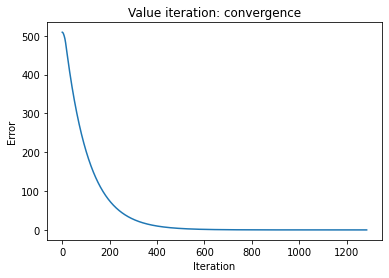

In [ ]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
#
greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma, tol)

# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
    "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
    "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

The second method, uniformly sampling, is better because it allow us to explore more state-action pairs, in particular pairs with high reward. Following a random policy doesn't ensure that we will get a representative sample of all state-action pairs. This is especially harmful in the gridworld example, where most of the states give zero reward. We want to make sure that we visit states with high reward, so a uniform sampling is better because we have more chances of sampling a high reward state by uniformly sampling than following some random policy and hoping to get to the high reward state.

In [ ]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


In [ ]:
# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs
def estimate_reward_and_transition(dataset, Ns, Na):
    states, actions, rewards, next_states = dataset
    N_samples = len(states)
    R = np.zeros((Ns, Na))
    P = np.zeros((Ns, Na, Ns)) # s, a, s'
    count = dict()

    for i in range(N_samples):
        s, a, r, next_s = states[i], actions[i], rewards[i], next_states[i]
        if (s, a) in count:
            count[(s, a)] += 1
        else:
            count[(s, a)] = 1

        R[s, a] += r
        P[s, a, next_s] += 1

    for (s,a), freq in count.items():
        R[s, a] /= freq
        P[s, a, :] /= freq
    return R, P

R1, P1 = estimate_reward_and_transition(dataset_1, env.Ns, env.Na)
R2, P2 = estimate_reward_and_transition(dataset_2, env.Ns, env.Na)

In [ ]:
# Compare results with those obtained with the full MDP

policy_opt, value_opt = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
policy_1, value_1 = policy_iteration(P1, R1, gamma=gamma, tol=tol)
policy_2, value_2 = policy_iteration(P2, R2, gamma=gamma, tol=tol)

error1 = np.linalg.norm(value_1 - value_opt, ord=np.inf)
error2 = np.linalg.norm(value_2 - value_opt, ord=np.inf)

print(f'||V1* - v* ||: {error1}')
print(f'||V2* - v* ||: {error2}')


print(f'N° states where policy_1 and policy_opt differ: {np.sum(policy_1 !=policy_opt)}')
print(f'N° states where policy_2 and policy_opt differ: {np.sum(policy_2 !=policy_opt)}')


||V1* - v* ||: 99.99999999999993
||V2* - v* ||: 2.9610444373351186
N° states where policy_1 and policy_opt differ: 30
N° states where policy_2 and policy_opt differ: 9


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) simulation lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

For the simulation lemma we have that for all $\bar{s}$:

$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$

$ ||\hat{V} - V^*||_\infty \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| +  \frac{\gamma}{1-\gamma} \max_{s,a} \left|\sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$


$ ||\hat{V} - V^*||_\infty \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| + \frac{\gamma}{1-\gamma} \max_{s,a} \sum_{s'} \left|(P(s'|s,a) - \hat{P}(s'|s,a))\right| |V^*(s')|$

$ ||\hat{V} - V^*||_\infty \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| + \frac{\gamma}{1-\gamma}  \sum_{s'}\max_{s,a} \left|(P(s'|s,a) - \hat{P}(s'|s,a))\right| |V^*(s')|$

Since $R$ is bounded in $[0,1]$ then $|V^*(s)| \leq \frac{1}{1-\gamma}$ for all $s$:

$$ ||\hat{V} - V^*||_\infty \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| + \frac{\gamma}{(1-\gamma)^2} \sum_{s'} \max_{s,a} \left|(P(s'|s,a) - \hat{P}(s'|s,a))\right| $$


Let $\epsilon > 0$, using of the Hoeffding's Inequality we know that

$\mathbb{P}(\max_{s,a} \left| R(s,a) - \hat{R}(s,a) \right| \leq \epsilon) = \mathbb{P}(\left| R(s,a) - \hat{R}(s,a) \right| \leq \epsilon)^{SA} \geq (1 - 2e^{-2N\epsilon^2})^{SA}$

$\mathbb{P}(\max_{s,a} \left| P(s,a) - \hat{P}(s,a) \right| \leq \epsilon) = \mathbb{P}(\left| P(s,a) - \hat{P}(s,a) \right| \leq \epsilon)^{SA} \geq (1 - 2e^{-2N\epsilon^2})^{SA}$

So far we have:

$$ ||\hat{V} - V^*||_\infty \leq \frac{1}{1-\gamma}\epsilon + \frac{\gamma S}{(1-\gamma)^2} \epsilon  = \epsilon \frac{1+\gamma(S-1)}{(1-\gamma)^2}$$

Then it follows that:

$$\mathbb{P}\left(||\hat{V} - V^*||_\infty \leq \epsilon\frac{1+\gamma(S-1)}{(1-\gamma)^2}\right)  \geq (1 - 2e^{-2N\epsilon^2})^{2SA}$$

Then we impose

$(1 - 2e^{-2N\epsilon^2})^{2SA} = 1 - \delta$. Therefore $\epsilon = \sqrt{\frac{1}{2N}\log\left(\frac{2}{1-\sqrt[2SA]{1-\delta}}\right)}$


To sum up: if we want $\mathbb{P}\left(||\hat{V} - V^*||_\infty \leq B_\delta \right) \geq 1 - \delta$ the bound is:

$$B_\delta = \frac{1+\gamma(S-1)}{(1-\gamma)^2}\sqrt{\frac{1}{2N}\log\left(\frac{2}{1-\sqrt[2SA]{1-\delta}}\right)}$$



## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?


### **Answer**

a) Since Q-learning is off-policy, we could leverage the offline data by using a model based procedure similar to Dyna-Q. This means that after the Q-Learning update we can estimate the MDP model and add a planning step using the offline data as "replay experience".

b) SARSA is on-policy (the TD update is done using the same policy used to sample actions). So, if we use the dataset to make updates on $\hat{Q}$ we are not actually using the SARSA policy.


# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

## **Answer**

In the linear case we seek to minimize the following cost function $C$ with respect to $\theta$
$$
C(\theta)= \frac{1}{2}\sum_{i=1}^N
\left(
  \phi(s_i)^T\theta_{a_i} - y_i^k
\right)^2 + \lambda \frac{1}{2}\sum_a ||\theta_a||_2^2
$$

The derivative of $C$ with respect to $\theta_{a}$ is set to zero: 

$$
\frac{d}{d\theta_{a_j}}C(\theta) =
\sum_{i=1}^N 1_{a_i = a} 
(
  \phi(s_i)^T\theta_{a_i} - y_i^k)\phi(s_i)
+ \lambda\theta_{a} = 0
$$

$$
\sum_{i=1/a_i=a}^N
(\phi(s_i)^T\theta_{a} - y_i^k)\phi(s_i)
+ \lambda\theta_{a} = 0
$$

$$
\sum_{i=1/a_i=a}^N
((\phi(s_i)^T\theta_{a} - y_i^k)\phi(s_i)
+ \lambda\theta_{a} = 0
$$

$$
\sum_{i=1/a_i=a}^N
\phi(s_i)\phi(s_i)^T\theta_{a} 
+ \lambda\theta_{a}
= \sum_{i=1/a_i=a}^N  y_i^k\phi(s_i)
$$

$$
\left( \sum_{i=1/a_i=a}^N
\phi(s_i)\phi(s_i)^T
+ \lambda I_{d\times d}
\right)\theta_{a}
= \sum_{i=1/a_i=a}^N  y_i^k\phi(s_i)
$$

Finally, we get a closed form for $\theta_a$:
$$
\theta_{a}
= 
\left( \sum_{i=1/a_i=a}^N
\phi(s_i)\phi(s_i)^T
+ \lambda I_{d\times d}
\right)^{-1}
\sum_{i=1/a_i=a}^N  y_i^k\phi(s_i)
$$


## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration. 

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

In order to reduce the approximation error we increased the dimension of the feature vector from $15$ to $150$. In addition, running FQI for more iterations also reduces the error. It is also possible to use a bigger dataset. 

In [ ]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [ ]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


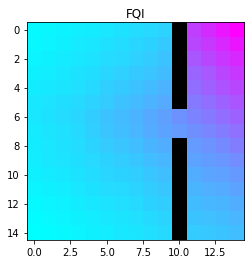

In [ ]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  n_samples = 10000
  dataset = get_uniform_dataset(env, n_samples=n_samples)
  states = np.array(dataset[0])
  actions = np.array(dataset[1])
  rewards = np.array(dataset[2])
  next_states = np.array(dataset[3])
  # OR dataset = get_random_policy_dataset(env, n_samples=...)


  theta = np.zeros((feat_map.dim, env.Na))
  all_features = feat_map.map(states)
  for it in range(num_iterations):
      Q = feat_map.map(next_states).T @ theta
      targets = rewards + gamma * np.max(Q, axis=1) 
      for a in range(env.Na):
          indices = np.where(actions == a)[0]
          features = all_features[:, indices] 
          A = features @ features.T + lambd * np.eye(feat_map.dim)  # shape (d,d)
          b = features @ targets[indices]  # shape (d,)
          theta[:, a] = np.linalg.solve(A, b)
    
      
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=150, sigma=0.25)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=1000)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.title("FQI")
plt.show()